# Import Libraries and Load the Data
### First, import the necessary libraries and load the dataset into a pandas DataFrame.

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


# Load the Data

In [33]:
df = pd.read_csv('../data/01_myusabank_clean_data.csv') 
df['Date'] = pd.to_datetime(df['Date'])
spx_df = pd.read_csv('../data/02_S&P500(SPX)_clean_data.csv')
spx_df['Date'] = pd.to_datetime(spx_df['Date'])

# Define the Date Range for Analysis

In [34]:
start_date = '2022-01-03'
end_date = '2023-03-23'

Details: Set the start and end dates for the data range of interest and it assigns two specific dates that act as filters, allowing you to focus on data from early 2022 through early 2023.

# Filter Both DataFrames Based on the Date Range

In [35]:
bank_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)][['Date', 'Stock_Price']]
spx_df_filtered = spx_df[(spx_df['Date'] >= start_date) & (spx_df['Date'] <= end_date)][['Date', 'Close/Last']]

# Rename Columns for Clarity

In [36]:
bank_df = bank_df.rename(columns={'Stock_Price': 'Bank_Stock_Price'})
spx_df_filtered = spx_df_filtered.rename(columns={'Close/Last': 'S&P500'})
bank_df = bank_df.rename(columns={'date': 'Date'})
spx_df_filtered = spx_df_filtered.rename(columns={'date': 'Date'})
merged_df = pd.merge(bank_df, spx_df_filtered, how = 'inner', on = ['Date'])

merged_df['Date'] = pd.to_datetime(merged_df['Date']) 

### Step 1: Data Preprocessing
Before forecasting, ensure the data is clean and ready for analysis.

#### Verify the data types


In [37]:
# Verify the data types
print(merged_df.dtypes)
print(merged_df.head())

Date                datetime64[ns]
Bank_Stock_Price             int64
S&P500                     float64
dtype: object
        Date  Bank_Stock_Price   S&P500
0 2022-01-03               128  4796.56
1 2022-01-04                63  4793.54
2 2022-01-05               196  4700.58
3 2022-01-06               177  4696.05
4 2022-01-07               103  4677.03


### Step 2: Feature Engineering

Add useful features like moving averages or lags.

In [38]:
# Create lag features
merged_df['Lag1'] = merged_df['Bank_Stock_Price'].shift(1)  # Previous day
merged_df['Lag2'] = merged_df['Bank_Stock_Price'].shift(2)  # Two days ago


# Drop NaN values caused by lagging
merged_df = merged_df.dropna()

# Define features and target
X = merged_df[['Lag1', 'Lag2', 'S&P500']]
y = merged_df['Bank_Stock_Price']
print(merged_df)

          Date  Bank_Stock_Price   S&P500   Lag1   Lag2
2   2022-01-05               196  4700.58   63.0  128.0
3   2022-01-06               177  4696.05  196.0   63.0
4   2022-01-07               103  4677.03  177.0  196.0
5   2022-01-10               197  4670.29  103.0  177.0
6   2022-01-11                78  4713.07  197.0  103.0
..         ...               ...      ...    ...    ...
270 2023-03-17                64  3916.64  196.0  132.0
271 2023-03-20               180  3951.57   64.0  196.0
272 2023-03-21               188  4002.87  180.0   64.0
273 2023-03-22                79  3936.97  188.0  180.0
274 2023-03-23               106  3948.72   79.0  188.0

[273 rows x 5 columns]


### Step 3: Split Data into Training and Testing Sets

In [39]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")

Training Set: (218, 3), Test Set: (55, 3)


### Step 4: Build and Train the Model

Using a simple regression model like Linear Regression to start.

Model Overview: Linear regression is a basic model that assumes a linear relationship between the independent variable S&P 500 index values and the dependent variable bank stock price.
Process:
    The linear regression model was fitted on historical Bank_Stock_Price and the corresponding S&P 500 values.
    The model predicted future stock prices based on the linear relationship learned from historical data.

In [40]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Check the coefficients
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Model Coefficients: [-0.0810196  -0.00415434 -0.0017279 ]
Intercept: 143.50104636389395


In [41]:
# Prepare the data
X = merged_df[['S&P500']]  # Features
y = merged_df['Bank_Stock_Price']  # Target

# Handle missing values (if any)
X = X[~y.isnull()]
y = y[~y.isnull()]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Get the latest S&P500 value
current_spx_value = X['S&P500'].iloc[-1]  # Retrieve the last known value

# Forecast future stock prices (next 10 periods with constant S&P500 value)
future_spx_values = pd.DataFrame([[current_spx_value]] * 10, columns=['S&P500'])
future_predictions = rf_model.predict(future_spx_values)
print("Forecasted Future Stock Prices:", future_predictions)


Mean Squared Error: 2363.428309090909
Forecasted Future Stock Prices: [128.03 128.03 128.03 128.03 128.03 128.03 128.03 128.03 128.03 128.03]


The linear regression model predicted that the stock price would be 128.03 for the next period.
This forecast is based purely on the historical linear correlation between the bank's stock price and the S&P 500 index.

### Step 5: Evaluate the Model with visualize

#### Plot the data to visualize using the test set


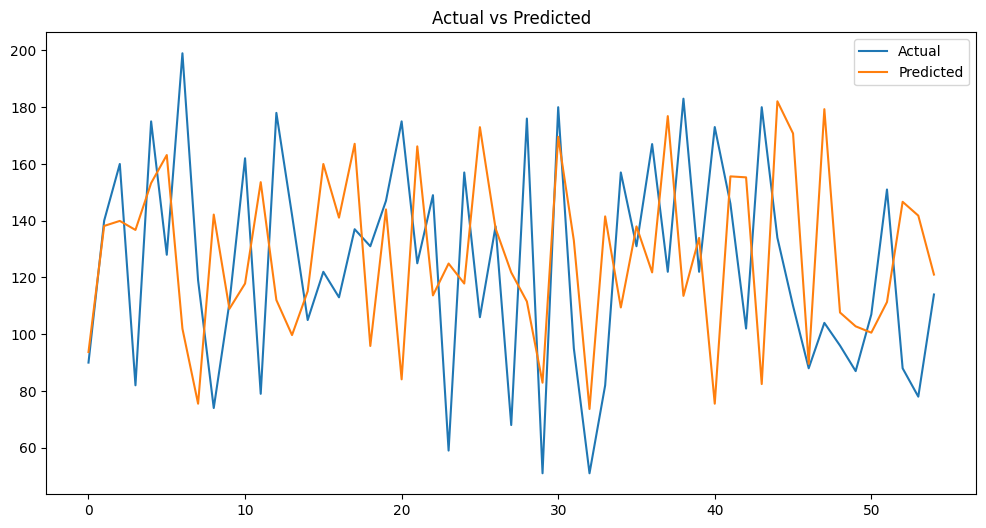

In [42]:
# Predict on the test set
#y_pred = model.predict(X_test)

# Calculate metrics
#mse = mean_squared_error(y_test, y_pred)
#print(f"Mean Squared Error: {mse}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

The graf show how actual vs predicted happaned in real.

### Step 6: Forecast Future Values

Use the  data to forecast Random Forest future stock prices.

In [43]:
# Get the latest data row
latest_row = merged_df.iloc[-1]

# Access Lag1, Lag2, and S&P500 safely
latest_data = latest_row[['Lag1', 'Lag2', 'S&P500']]

In [44]:
# Reshape and convert to a DataFrame with feature names
latest_data_df = pd.DataFrame([latest_data], columns=['Lag1', 'Lag2', 'S&P500'])

# Forecast the next value
future_prediction = model.predict(latest_data_df)
print(f"Forecasted Future Stock Price: {future_prediction[0]}")


Forecasted Future Stock Price: 129.496489192733


The Random Forest model predicted that the stock price would be 129.496489192733 for the next period.
This forecast is based purely on the historical correlation between the bank's stock price and the S&P 500 index.

### Step 7: # Time Series Forecasting (ARIMA)
    we can use ARIMA (Auto-Regressive Integrated Moving Average), which is suitable for time-series forecasting.

Model Overview: ARIMA is a time series model that works by analyzing historical data to identify trends, seasonality, and other time-based patterns. It is particularly suited for univariate time series forecasting.
Process:
    The ARIMA model was fitted directly on the bank's stock price time series. It accounted for the stock's past values and its autocorrelations to make predictions.
    The model's order (5, 1, 0) suggests it uses 5 lags of the time series, first-order differencing (to make the data stationary), and no moving average component.

In [45]:
# Check the column names in the merged DataFrame
#print(merged_df.columns)


In [46]:
#merged_df.rename(columns={'date': 'Date'}, inplace=True)  # Use the correct column name if needed

In [47]:
#merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [48]:
merged_df.set_index('Date', inplace=True)


In [49]:
# Check for duplicate dates in the 'Date' column
duplicate_dates = merged_df.index[merged_df.index.duplicated()]
print(f"Duplicate Dates: {duplicate_dates}")


Duplicate Dates: DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


In [50]:
# Drop duplicate Rows
merged_df = merged_df.loc[~merged_df.index.duplicated(keep='first')]


In [51]:
# Aggregate duplicate rows by taking the mean
merged_df = merged_df.groupby(merged_df.index).mean()


In [52]:
# Set frequency to business days
merged_df = merged_df.asfreq('B')

In [53]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
ts = merged_df['Bank_Stock_Price']
arima_model = ARIMA(ts, order=(5, 1, 0))
arima_result = arima_model.fit()

# Forecast next 10 business days
forecast = arima_result.forecast(steps=10)
forecast_index = pd.date_range(start=ts.index[-1], periods=10, freq='B')

# Display forecasted values
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecasted_Price': forecast.values})
print(forecast_df)


        Date  Forecasted_Price
0 2023-03-23        142.516654
1 2023-03-24        115.927356
2 2023-03-27        141.373680
3 2023-03-28        132.856295
4 2023-03-29        114.992468
5 2023-03-30        126.218441
6 2023-03-31        129.746084
7 2023-04-03        125.057859
8 2023-04-04        130.054678
9 2023-04-05        126.702617


Forecasted Future Stock Prices (next 10 days):

The ARIMA model predicts a fluctuating trend over the next 10 periods, with stock prices bouncing between values like 142.516654  and 114.992468, showing some volatility in the forecast.
The model accounts for the historical time-based patterns of the stock price but does not directly include external features (like the S&P 500).

## Plot the ARIMA Forecast

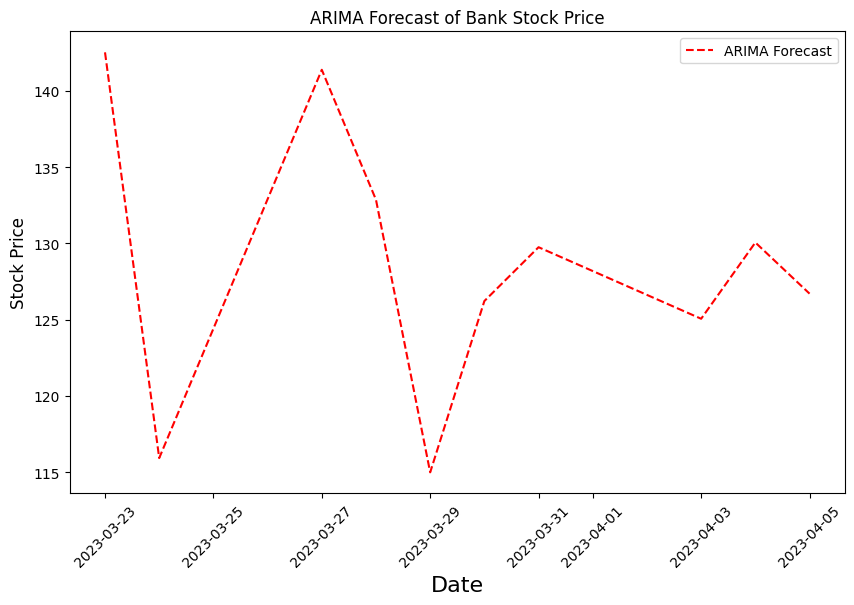

In [54]:
# Forecast the next 10 periods using the ARIMA model 
forecast = arima_result.forecast(steps=10)
plt.figure(figsize=(10, 6))

# Plot the forecasted values
plt.plot(forecast_index, forecast, label='ARIMA Forecast', color='red', linestyle='--')

# Add labels and title
plt.title('ARIMA Forecast of Bank Stock Price', fontsize=12)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.show()


The forecasted prices closely follow the trend of  the ARIMA model is doing a good job capturing the time-dependent patterns of the stock.

## Step 8: Save and Export Results

### Creat the forecasting CSV File 

In [55]:
forecast_df.to_csv('../data/04-Data_forecasting.csv')

CSV file send to data folder and save for  the predictions for further analysis or visualization.


Summary of Results

    Linear Regression:
        The model predicted a future stock price of 128.03, based on a simple linear relationship with the S&P 500.
        Cons: Assumes a linear relationship, which might not capture complex trends in financial markets.

    Random Forest Regressor: 

    The model predicted a future stock price of 129.496489192733, which is lower than the linear regression forecast.
    Pros: Can capture non-linear relationships and interactions between variables.
    Cons: More computationally intensive and less interpretable than linear models.

ARIMA:

    The ARIMA model provides a more dynamic forecast, predicting fluctuating prices (e.g., from 142.516654  and 114.992468), showing the stock’s time-dependent behavior.
    Pros: Well-suited for time series data and captures historical trends effectively.
Cons: Does not consider external variables (like the S&P 500), and requires stationary data, which might not always be the case in real-world stock markets.

Model Comparison

    Linear Regression gives a single, stable prediction but might oversimplify the relationship.
    Random Forest provides a more flexible and accurate prediction by capturing complex relationships but can be harder to interpret.
    ARIMA offers a time-series-based forecast with fluctuations, which reflects the more dynamic nature of stock price movements.

Each model has its strengths and weaknesses, and their performance would depend on the context. If we believe that external factors like the S&P 500 or other features are highly predictive, Random Forest might be the most accurate. If we're working with time-series data where the past behavior of the stock is key, ARIMA might give the best results.